<a href="https://colab.research.google.com/github/DoggoWoofWoof/Implementation-of-GANS/blob/main/Sketch2Object%20Implementations/aladdin_persson_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision.utils import save_image
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import os
import torch
import numpy as np
from PIL import Image
import os
from torchvision.utils import save_image
from torchvision import transforms
import matplotlib.pyplot as plt


In [ ]:
!wget https://efrosgans.eecs.berkeley.edu/pix2pix/datasets/edges2shoes.tar.gz
!tar -xvf edges2shoes.tar.gz -C .
!mv edges2shoes data

Streaming output truncated to the last 5000 lines.
edges2shoes/train/46382_AB.jpg
edges2shoes/train/46383_AB.jpg
edges2shoes/train/46384_AB.jpg
edges2shoes/train/46385_AB.jpg
edges2shoes/train/46386_AB.jpg
edges2shoes/train/46387_AB.jpg
edges2shoes/train/46388_AB.jpg
edges2shoes/train/46389_AB.jpg
edges2shoes/train/4638_AB.jpg
edges2shoes/train/46390_AB.jpg
edges2shoes/train/46391_AB.jpg
edges2shoes/train/46392_AB.jpg
edges2shoes/train/449_AB.jpg
edges2shoes/train/44_AB.jpg
edges2shoes/train/45000_AB.jpg
edges2shoes/train/45001_AB.jpg
edges2shoes/train/45002_AB.jpg
edges2shoes/train/45003_AB.jpg
edges2shoes/train/45004_AB.jpg
edges2shoes/train/45005_AB.jpg
edges2shoes/train/45006_AB.jpg
edges2shoes/train/45007_AB.jpg
edges2shoes/train/45008_AB.jpg
edges2shoes/train/45009_AB.jpg
edges2shoes/train/4500_AB.jpg
edges2shoes/train/45010_AB.jpg
edges2shoes/train/45011_AB.jpg
edges2shoes/train/45012_AB.jpg
edges2shoes/train/45013_AB.jpg
edges2shoes/train/45687_AB.jpg
edges2shoes/train/45688_AB

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRAIN_DIR = "data/train"
VAL_DIR = "data/val"
LEARNING_RATE = 2e-4
BATCH_SIZE = 16
NUM_WORKERS = 2
IMAGE_SIZE = 256
CHANNELS_IMG = 3
L1_LAMBDA = 100
LAMBDA_GP = 10
NUM_EPOCHS = 500
SAVE_MODEL = True
CHECKPOINT_DISC = "disc.pth.tar"
CHECKPOINT_GEN = "gen.pth.tar"

both_transform = A.Compose(
    [A.Resize(width=256, height=256),], additional_targets={"image0": "image"},
)

transform_only_input = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.ColorJitter(p=0.2),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        ToTensorV2(),
    ]
)

transform_only_mask = A.Compose(
    [
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        ToTensorV2(),
    ]
)

In [ ]:
root_dir = "data/train/"

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.file_names = os.listdir(root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        file_path = os.path.join(self.root_dir, self.file_names[idx])
        image = np.array(Image.open(file_path))
        input_image = image[:, :image.shape[1]//2, :]
        target_image = image[:, image.shape[1]//2:, :]

        if self.transform:
            augmented = self.transform(image=input_image, image0=target_image)
            input_image = augmented["image"]
            target_image = augmented["image0"]

        input_image = transform_only_input(image=input_image)["image"]
        target_image = transform_only_mask(image=target_image)["image"]

        return input_image, target_image

def get_data_loader(root_dir, batch_size, shuffle=True, num_workers=2):
    dataset = CustomDataset(root_dir, transform=both_transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    return loader

# Create the DataLoader
loader = get_data_loader(root_dir, batch_size=5)

# Iterate through the DataLoader
for x, y in loader:
    print(x.shape)
    save_image(x, "x.png")
    save_image(y, "y.png")
    break

torch.Size([5, 3, 256, 256])


In [ ]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(CNNBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, 4, stride, 1, bias=False, padding_mode="reflect"
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.conv(x)


class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels * 2,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                CNNBlock(in_channels, feature, stride=1 if feature == features[-1] else 2),
            )
            in_channels = feature

        layers.append(
            nn.Conv2d(
                in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"
            ),
        )

        self.model = nn.Sequential(*layers)

    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        x = self.initial(x)
        x = self.model(x)
        return x


def test():
    x = torch.randn((1, 3, 256, 256))
    y = torch.randn((1, 3, 256, 256))
    model = Discriminator(in_channels=3)
    preds = model(x, y)
    print(model)
    print(preds.shape)



test()

Discriminator(
  (initial): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (model): Sequential(
    (0): CNNBlock(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (1): CNNBlock(
      (conv): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (2): CNNBlock(
      (conv): Sequential(
        (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=reflect)
        (1): Batc

In [ ]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super(Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode="reflect")
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )

        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        self.down = down

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x


class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )
        self.down1 = Block(features, features * 2, down=True, act="leaky", use_dropout=False)
        self.down2 = Block(
            features * 2, features * 4, down=True, act="leaky", use_dropout=False
        )
        self.down3 = Block(
            features * 4, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down4 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down5 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down6 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features * 8, features * 8, 4, 2, 1), nn.ReLU()
        )

        self.up1 = Block(features * 8, features * 8, down=False, act="relu", use_dropout=True)
        self.up2 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up3 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up4 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=False
        )
        self.up5 = Block(
            features * 8 * 2, features * 4, down=False, act="relu", use_dropout=False
        )
        self.up6 = Block(
            features * 4 * 2, features * 2, down=False, act="relu", use_dropout=False
        )
        self.up7 = Block(features * 2 * 2, features, down=False, act="relu", use_dropout=False)
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features * 2, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7], 1))
        up3 = self.up3(torch.cat([up2, d6], 1))
        up4 = self.up4(torch.cat([up3, d5], 1))
        up5 = self.up5(torch.cat([up4, d4], 1))
        up6 = self.up6(torch.cat([up5, d3], 1))
        up7 = self.up7(torch.cat([up6, d2], 1))
        return self.final_up(torch.cat([up7, d1], 1))


def test():
    x = torch.randn((1, 3, 256, 256))
    model = Generator(in_channels=3, features=64)
    preds = model(x)
    print(preds.shape)



test()

torch.Size([1, 3, 256, 256])


In [ ]:
def save_some_examples(gen, val_loader, epoch, folder):
    # Create the folder if it doesn't exist
    if not os.path.exists(folder):
        os.makedirs(folder)

    x, y = next(iter(val_loader))
    x, y = x.to(DEVICE), y.to(DEVICE)
    gen.eval()
    with torch.no_grad():
        y_fake = gen(x)
        y_fake = y_fake * 0.5 + 0.5  # remove normalization
        save_image(y_fake, os.path.join(folder, f"y_gen_{epoch}.png"))
        save_image(x * 0.5 + 0.5, os.path.join(folder, f"input_{epoch}.png"))
        if epoch == 1:
            save_image(y * 0.5 + 0.5, os.path.join(folder, f"label_{epoch}.png"))
    gen.train()


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer=None, lr=None):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])

    if optimizer is not None:
        optimizer.load_state_dict(checkpoint["optimizer"])
        if lr is not None:
            # If we don't do this then it will just have learning rate of old checkpoint
            # and it will lead to many hours of debugging \:
            for param_group in optimizer.param_groups:
                param_group["lr"] = lr

In [ ]:
def train_fn(disc, gen, loader, opt_disc, opt_gen, l1_loss, bce, g_scaler, d_scaler):
    loop = tqdm(loader, leave=True)

    for idx, (x, y) in enumerate(loop):
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        # Train Discriminator
        with torch.cuda.amp.autocast():
            y_fake = gen(x)
            D_real = disc(x, y)
            D_real_loss = bce(D_real, torch.ones_like(D_real))
            D_fake = disc(x, y_fake.detach())
            D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
            D_loss = (D_real_loss + D_fake_loss) / 2

        disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train generator
        with torch.cuda.amp.autocast():
            D_fake = disc(x, y_fake)
            G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
            L1 = l1_loss(y_fake, y) * L1_LAMBDA
            G_loss = G_fake_loss + L1

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        if idx % 10 == 0:
            loop.set_postfix(
                D_real=torch.sigmoid(D_real).mean().item(),
                D_fake=torch.sigmoid(D_fake).mean().item(),
                D_loss=D_loss.item(),
                G_loss=G_loss.item(),
            )

def main():
    disc = Discriminator(in_channels=3).to(DEVICE)
    gen = Generator(in_channels=3, features=64).to(DEVICE)
    opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
    opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
    BCE = nn.BCEWithLogitsLoss()
    L1_LOSS = nn.L1Loss()

    if LOAD_MODEL:
        load_checkpoint(CHECKPOINT_GEN, gen, opt_gen, LEARNING_RATE)
        load_checkpoint(CHECKPOINT_DISC, disc, opt_disc, LEARNING_RATE)

    train_loader = get_data_loader(TRAIN_DIR, BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    val_loader = get_data_loader(VAL_DIR, batch_size=1, shuffle=False)

    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()

    # Disable CuDNN benchmarking
    torch.backends.cudnn.benchmark = False

    for epoch in range(NUM_EPOCHS):
        train_fn(disc, gen, train_loader, opt_disc, opt_gen, L1_LOSS, BCE, g_scaler, d_scaler)

        if SAVE_MODEL and epoch % 1 == 0:
            save_checkpoint(gen, opt_gen, filename=CHECKPOINT_GEN)
            save_checkpoint(disc, opt_disc, filename=CHECKPOINT_DISC)

        save_some_examples(gen, val_loader, epoch, folder="evaluation")

main()

100%|██████████| 3115/3115 [17:51<00:00,  2.91it/s, D_fake=0.508, D_loss=0.96, D_real=0.26, G_loss=21]


=> Saving checkpoint
=> Saving checkpoint


  0%|          | 4/3115 [00:02<25:58,  2.00it/s, D_fake=0.405, D_loss=1.06, D_real=0.257, G_loss=24.3]


KeyboardInterrupt: 

=> Loading checkpoint
Input image saved to: /content/output/input_image.png
Generated image saved to: /content/output/generated_image.png


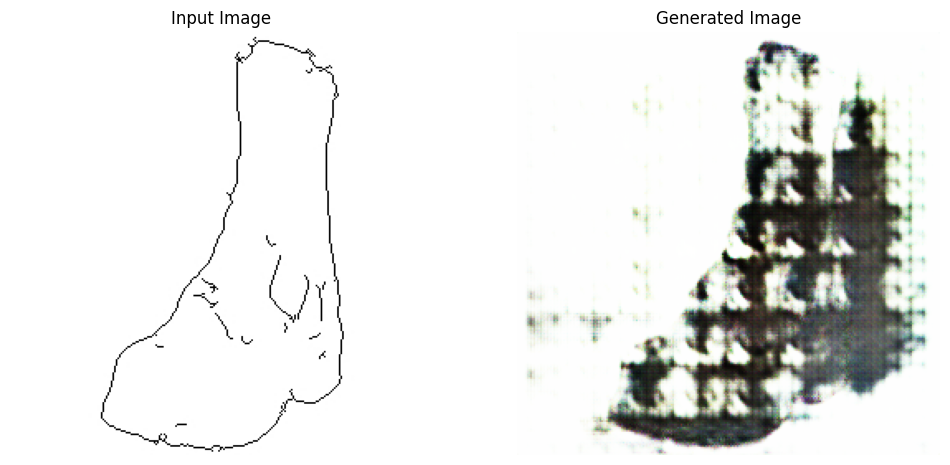

In [ ]:
def test_generator(gen, checkpoint_path, input_image_path, output_folder):
    # Load the checkpoint
    load_checkpoint(checkpoint_path, gen)

    # Set the generator to evaluation mode
    gen.eval()

    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Load and resize the input image
    image = Image.open(input_image_path).convert("RGB")
    image = image.resize((256, 256), Image.BILINEAR)
    input_image = np.array(image)

    # Apply the same transformations as in your dataset
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])

    input_image = transform(input_image)

    # Add batch dimension and move to device
    input_tensor = input_image.unsqueeze(0).to(DEVICE)

    # Generate the output image
    with torch.no_grad():
        output_tensor = gen(input_tensor)

    # Save the input and output images
    input_path = os.path.join(output_folder, f"input_{os.path.basename(input_image_path)}")
    output_path = os.path.join(output_folder, f"generated_{os.path.basename(input_image_path)}")

    save_image(input_tensor, input_path)
    save_image(output_tensor, output_path)

    print(f"Input image saved to: {input_path}")
    print(f"Generated image saved to: {output_path}")

    # Display images using matplotlib
    input_image_np = input_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    input_image_np = (input_image_np * 0.5 + 0.5)  # Unnormalize

    output_image_np = output_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    output_image_np = (output_image_np * 0.5 + 0.5)  # Unnormalize

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(input_image_np)
    axes[0].set_title("Input Image")
    axes[0].axis("off")

    axes[1].imshow(output_image_np)
    axes[1].set_title("Generated Image")
    axes[1].axis("off")

    plt.show()

# Example usage
def main():
    # Initialize your generator model
    gen = Generator(in_channels=3, features=64).to(DEVICE)

    # Set paths
    checkpoint_path = "/content/gen.pth.tar"
    input_image_path = "/content/image.png"
    output_folder = "/content/output"

    # Test the generator
    test_generator(gen, checkpoint_path, input_image_path, output_folder)

main()